# Classification for PSK


This notebook uses PSK and QAM families dataset for training customized EffiecientNet models. the dataset consists of 130K samples for 13 classes to be classifed, so there are 10K samples for each class

### Import Libraries

In [3]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b0, efficientnet_b2,efficientnet_b4
from xcit.xcit import xcit_tiny12, xcit_nano
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import os
import shutil
from torch.utils.data import Subset
from sigPSK import Sig53
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from Train_evaluate import *
from torch import nn, optim

----
### Data reading

In [4]:
selected_classes = [
    "bpsk",
    "qpsk",
    "8psk",
    "16psk",
    "32psk",
    ]

In [5]:
# Specify Sig53 Options
root = "../../../../data/torchsig/sigQAM/"
train = True
impaired = True
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Dataset length: 200000
Data shape: (2, 4096)
Label Index: 0
Label Class: bpsk


----
### Dataloaders

In [6]:
# Calculate the size of the validation set (10% of the training set)
val_size = int(0.1 * len(sig53_clean_train))
train_size = len(sig53_clean_train) - val_size

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sig53_clean_train, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Call and Train Model
Loading the model structure to be trained

#### Efficientnet B0

In [5]:
model = efficientnet_b0(
    pretrained=False,
    num_classes=len(selected_classes)
)

device = torch.device('cuda')
                      #cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

----
### Training

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [7]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 5625/5625 [07:14<00:00, 12.96it/s, loss=1.3313, accuracy=33.99%]


Epoch 1: Train Loss 1.3310, Acc 33.99%, Val Loss 1.1915, Val Acc 39.91%
Epoch 2/20


Training: 100%|██████████| 5625/5625 [07:24<00:00, 12.65it/s, loss=1.1165, accuracy=44.12%]


Epoch 2: Train Loss 1.1163, Acc 44.12%, Val Loss 1.0932, Val Acc 44.60%
Epoch 3/20


Training: 100%|██████████| 5625/5625 [07:27<00:00, 12.57it/s, loss=1.0433, accuracy=46.66%]


Epoch 3: Train Loss 1.0431, Acc 46.66%, Val Loss 1.0130, Val Acc 47.43%
Epoch 4/20


Training: 100%|██████████| 5625/5625 [07:30<00:00, 12.48it/s, loss=1.0080, accuracy=47.84%]


Epoch 4: Train Loss 1.0078, Acc 47.84%, Val Loss 0.9828, Val Acc 48.49%
Epoch 5/20


Training: 100%|██████████| 5625/5625 [07:34<00:00, 12.36it/s, loss=0.9724, accuracy=49.26%]


Epoch 5: Train Loss 0.9722, Acc 49.26%, Val Loss 0.9525, Val Acc 49.46%
Epoch 6/20


Training: 100%|██████████| 5625/5625 [07:40<00:00, 12.21it/s, loss=0.9495, accuracy=49.96%]


Epoch 6: Train Loss 0.9493, Acc 49.96%, Val Loss 0.9329, Val Acc 50.51%
Epoch 7/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.19it/s, loss=0.9383, accuracy=50.34%]


Epoch 7: Train Loss 0.9381, Acc 50.34%, Val Loss 0.9298, Val Acc 50.02%
Epoch 8/20


Training: 100%|██████████| 5625/5625 [07:42<00:00, 12.17it/s, loss=0.9266, accuracy=50.72%]


Epoch 8: Train Loss 0.9264, Acc 50.72%, Val Loss 0.9133, Val Acc 51.06%
Epoch 9/20


Training: 100%|██████████| 5625/5625 [07:33<00:00, 12.39it/s, loss=0.9217, accuracy=50.89%]


Epoch 9: Train Loss 0.9215, Acc 50.89%, Val Loss 0.9114, Val Acc 51.19%
Epoch 10/20


Training: 100%|██████████| 5625/5625 [07:37<00:00, 12.30it/s, loss=0.9165, accuracy=51.16%]


Epoch 10: Train Loss 0.9164, Acc 51.16%, Val Loss 0.8955, Val Acc 51.65%
Epoch 11/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.18it/s, loss=0.9075, accuracy=51.20%]


Epoch 11: Train Loss 0.9073, Acc 51.20%, Val Loss 0.9347, Val Acc 50.22%
Epoch 12/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.18it/s, loss=0.9035, accuracy=51.79%]


Epoch 12: Train Loss 0.9033, Acc 51.79%, Val Loss 0.8856, Val Acc 52.74%
Epoch 13/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.19it/s, loss=0.8579, accuracy=55.36%]


Epoch 13: Train Loss 0.8578, Acc 55.36%, Val Loss 0.8289, Val Acc 56.97%
Epoch 14/20


Training: 100%|██████████| 5625/5625 [07:42<00:00, 12.17it/s, loss=0.8196, accuracy=57.31%]


Epoch 14: Train Loss 0.8195, Acc 57.31%, Val Loss 0.7850, Val Acc 58.17%
Epoch 15/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.18it/s, loss=0.8053, accuracy=57.92%]


Epoch 15: Train Loss 0.8051, Acc 57.92%, Val Loss 0.7891, Val Acc 58.47%
Epoch 16/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.19it/s, loss=0.7944, accuracy=58.34%]


Epoch 16: Train Loss 0.7942, Acc 58.34%, Val Loss 0.7798, Val Acc 58.74%
Epoch 17/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.20it/s, loss=0.7873, accuracy=58.48%]


Epoch 17: Train Loss 0.7872, Acc 58.48%, Val Loss 0.7690, Val Acc 59.27%
Epoch 18/20


Training: 100%|██████████| 5625/5625 [07:40<00:00, 12.23it/s, loss=0.7806, accuracy=58.78%]


Epoch 18: Train Loss 0.7804, Acc 58.78%, Val Loss 0.7651, Val Acc 58.67%
Epoch 19/20


Training: 100%|██████████| 5625/5625 [07:39<00:00, 12.25it/s, loss=0.7749, accuracy=58.97%]


Epoch 19: Train Loss 0.7748, Acc 58.97%, Val Loss 0.7635, Val Acc 59.60%
Epoch 20/20


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.18it/s, loss=0.7700, accuracy=59.15%]


Epoch 20: Train Loss 0.7699, Acc 59.15%, Val Loss 0.7614, Val Acc 59.08%
Loaded best model from best_model_checkpoint.pth


In [8]:
num_epochs = 10
trainer.run_training_loop(num_epochs)

Epoch 1/10


Training: 100%|██████████| 5625/5625 [07:42<00:00, 12.17it/s, loss=0.7709, accuracy=59.11%]


Epoch 1: Train Loss 0.7708, Acc 59.11%, Val Loss 0.7902, Val Acc 59.16%
Epoch 2/10


Training: 100%|██████████| 5625/5625 [07:39<00:00, 12.24it/s, loss=0.7656, accuracy=59.33%]
                                                                                                   

Epoch 2: Train Loss 0.7654, Acc 59.33%, Val Loss 0.7860, Val Acc 58.90%
Stopping early due to no improvement in validation accuracy.


In [9]:
num_epochs = 10
trainer.run_training_loop(num_epochs)

Epoch 1/10


Training: 100%|██████████| 5625/5625 [07:38<00:00, 12.26it/s, loss=0.7634, accuracy=59.34%]


Epoch 1: Train Loss 0.7633, Acc 59.34%, Val Loss 0.7541, Val Acc 59.61%
Epoch 2/10


Training: 100%|██████████| 5625/5625 [07:40<00:00, 12.21it/s, loss=0.7592, accuracy=59.77%]


Epoch 2: Train Loss 0.7590, Acc 59.77%, Val Loss 0.7562, Val Acc 59.52%
Epoch 3/10


Training: 100%|██████████| 5625/5625 [07:40<00:00, 12.22it/s, loss=0.7556, accuracy=59.74%]


Epoch 3: Train Loss 0.7554, Acc 59.74%, Val Loss 0.7416, Val Acc 60.59%
Epoch 4/10


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.19it/s, loss=0.7523, accuracy=59.83%]


Epoch 4: Train Loss 0.7522, Acc 59.83%, Val Loss 0.7405, Val Acc 60.13%
Epoch 5/10


Training: 100%|██████████| 5625/5625 [07:41<00:00, 12.18it/s, loss=0.7502, accuracy=59.85%]


Epoch 5: Train Loss 0.7500, Acc 59.85%, Val Loss 0.7716, Val Acc 59.71%
Epoch 6/10


Training: 100%|██████████| 5625/5625 [07:42<00:00, 12.16it/s, loss=0.7478, accuracy=60.06%]


Epoch 6: Train Loss 0.7477, Acc 60.06%, Val Loss 0.7394, Val Acc 60.45%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


----
### Evaluation

Validation Loss: 0.7416
Validation Accuracy: 60.59%
Average Inference Time per Batch: 0.0295 seconds


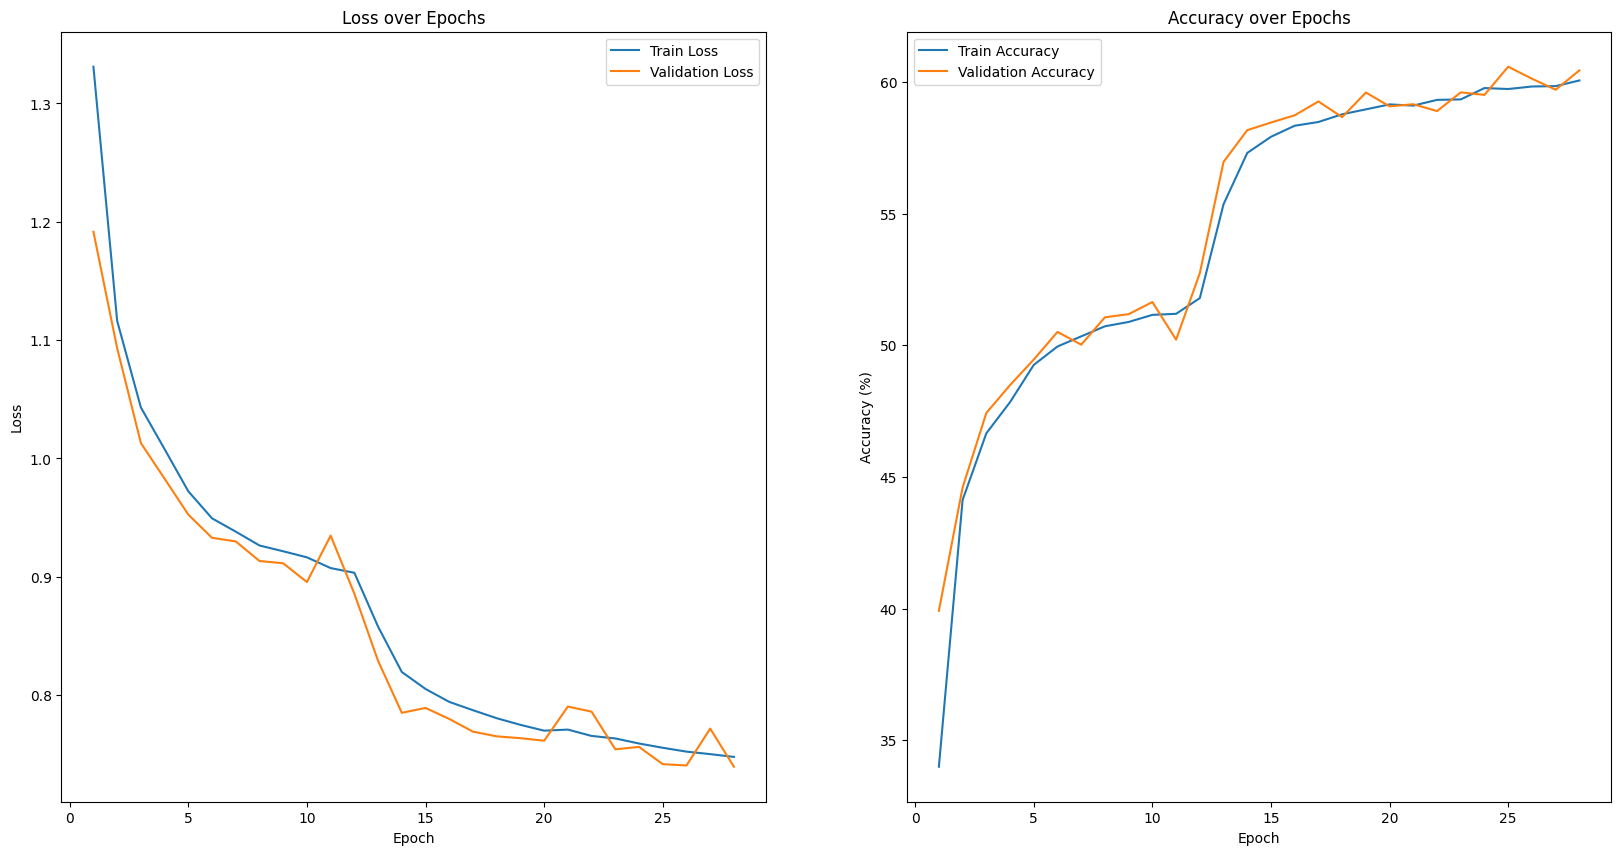

<Figure size 1500x1500 with 0 Axes>

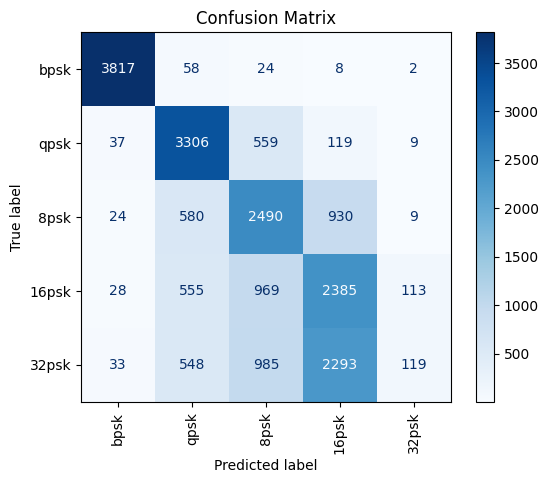

In [12]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [7]:
model = efficientnet_b4(
    pretrained=False,
    num_classes=len(selected_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [9]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 5625/5625 [21:33<00:00,  4.35it/s, loss=1.3824, accuracy=31.73%]


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 15.75 GiB total capacity; 8.71 GiB already allocated; 23.56 MiB free; 8.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Validation Loss: 0.7953
Validation Accuracy: 58.21%
Average Inference Time per Batch: 0.0434 seconds


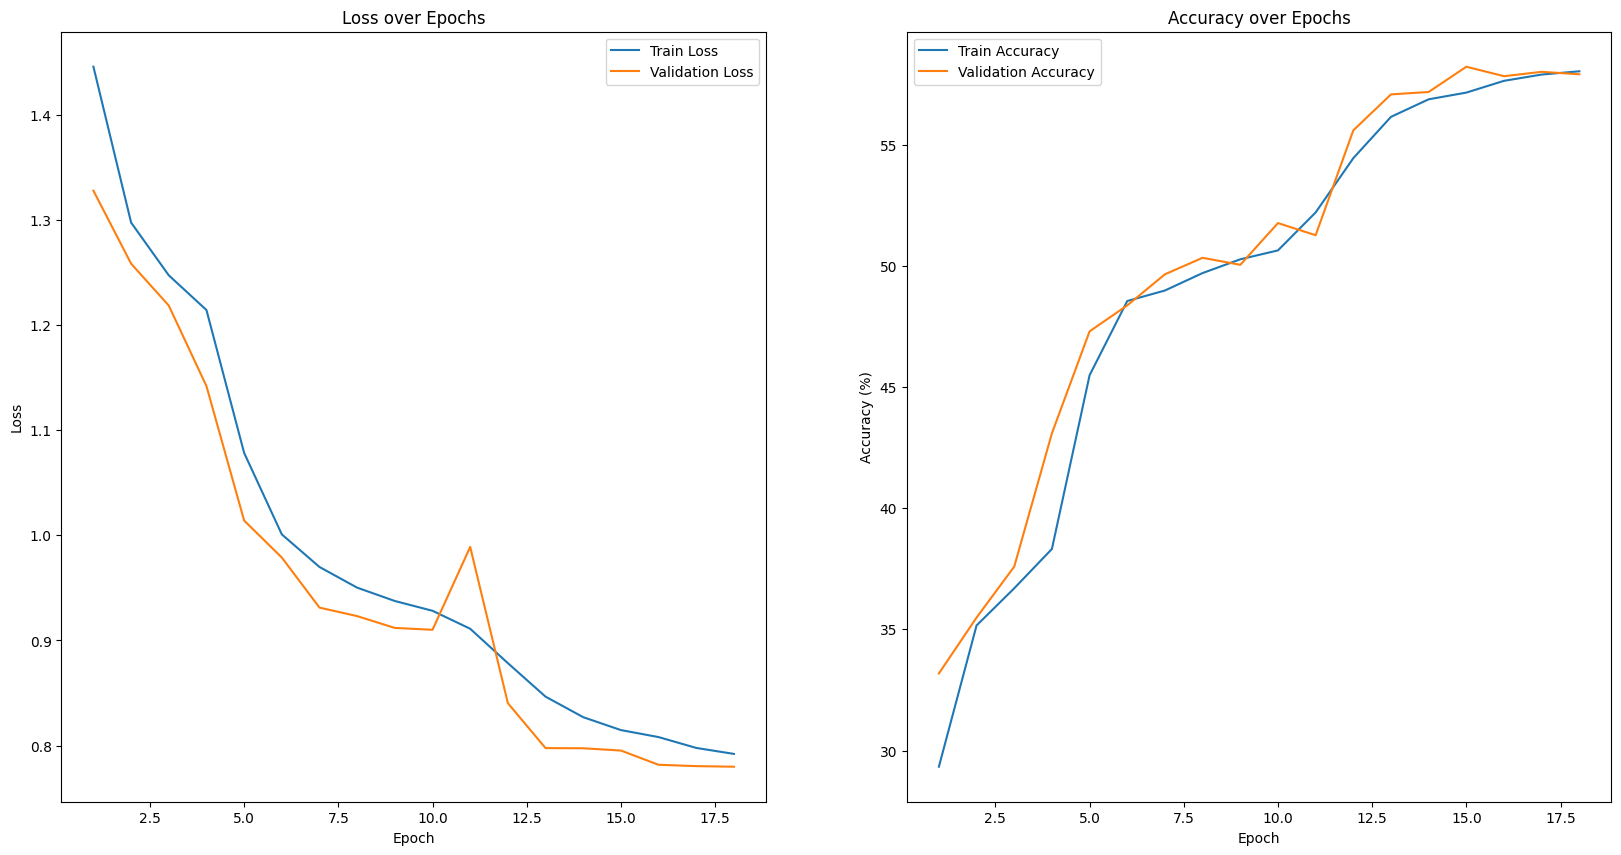

<Figure size 1500x1500 with 0 Axes>

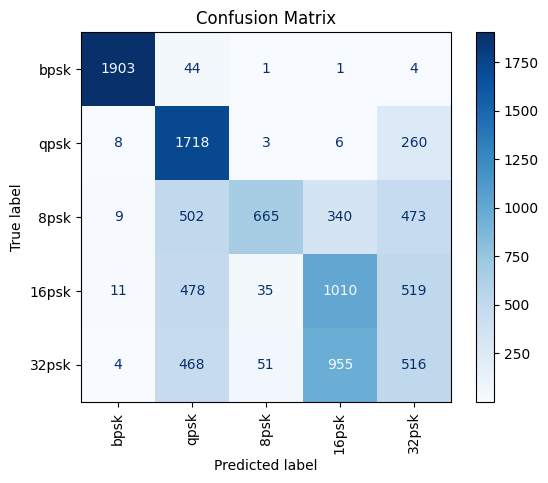

In [ ]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [12]:
model = xcit_nano(
    pretrained=False,
    num_classes=len(selected_classes)
)

device = torch.device('cuda')
model = model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.75 GiB total capacity; 9.61 GiB already allocated; 7.56 MiB free; 9.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

due to some issues with memory, batch size will be decreased to 8 instead of 32 as in the past models

In [10]:

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)


In [11]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training:   0%|          | 0/45000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.75 GiB total capacity; 9.61 GiB already allocated; 11.56 MiB free; 9.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
torch.save(trainer.model.state_dict(), './models/PSK_imp_xcitn')

In [12]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.7901
Validation Accuracy: 58.24%
Average Inference Time per Batch: 0.1327 seconds
